# ***Bank's points of attention in Guayaquil***

### Import libraries

In [0]:
!pip install reverse_geocoder
!pip install geopy
!pip install folium

print("Librerías instaladas")

In [0]:
import numpy as np
import reverse_geocoder as rg 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib notebook
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import requests
from pandas.io.json import json_normalize # Transformar Json a DataFrames

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # 
import folium # Mapas

print('Librarias importadas.')

Librarias importadas.


## **Business Understanding**
Due to the number of service points and the arrival of new players in the basic services market, digitization of services, it is necessary to have a correct analysis to place new service points (ATM, offices, Multifunction), to optimize costs and maximize the profitability of each point of care

# **Data Understanding**

### Import Bank dataset.  
Attention Points

In [0]:
data = pd.read_csv('limpioDataSet.csv', error_bad_lines=False,sep=";") 
data.head()

,Codigo,CodTipo,Tipo,coordenadas
0,79,1,Cajeros Automáticos,"-79.880615,-2.189985"
1,80,1,Cajeros Automáticos,"-79.879924,-2.191144"
2,81,1,Cajeros Automáticos,"-79.879511,-2.187539"
3,82,1,Cajeros Automáticos,"-79.898076,-2.181847"
4,83,1,Cajeros Automáticos,"-79.907486,-2.172754"


In [0]:
data.isna().sum()
#don't have Na in the data set

Codigo         0
CodTipo        0
Tipo           0
coordenadas    0
dtype: int64

In [0]:
# Frecuency data class Tipo
pd.value_counts(data['Tipo'])

Cajeros Automáticos     594
Oficinas                140
Cajeros Multifunción     78
Name: Tipo, dtype: int64

In [0]:
# tabla de frecuencia relativa de pasajeros
100 * data['Tipo'].value_counts() / len(data['Tipo'])

Cajeros Automáticos     73.152709
Oficinas                17.241379
Cajeros Multifunción     9.605911
Name: Tipo, dtype: float64

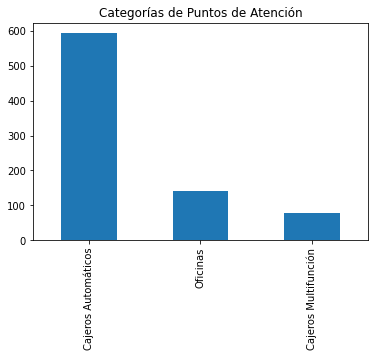

In [0]:
# Gráfico de barras de pasajeros del Titanic
plot = data['Tipo'].value_counts().plot(kind='bar',title='Categorías de Puntos de Atención')
plt.show()

# **Data Preparation**
### I clean the dataframe and separate the coordinates into longitude and latitude
The dataframe given to us by the bank does not have zero or null values, so we are not going to use a strategy to handle them

In [0]:
new = data["coordenadas"].str.split(",", n = 1, expand = True) 
   
data["longitud"]= new[0] 
  
data["latitud"]= new[1] 
  
data.drop(columns =["coordenadas"], inplace = True) 

### Validate that the column names are correct

In [0]:
data.columns

Index(['Codigo', 'CodTipo', 'Tipo', 'longitud', 'latitud'], dtype='object')

In [0]:
print('El dataframe tiene {} tipos de puntos de atención and {} ubicaciones.'.format(
        len(data['Tipo'].unique()),
        data.shape[0]
    )
)

El dataframe tiene 3 tipos de puntos de atención and 812 ubicaciones.


### Added to the dataframe of points of attention the city based on its coordinates

In [0]:
address = 'Guayaquil, Ecuador'

geolocator = Nominatim(user_agent="gye_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Las coordenadas de Guayaquil son {}, {}.'.format(latitude, longitude))

Las coordenadas de Guayaquil son -2.1899066, -79.887726.


In [0]:
# Iteración por filas del DataFrame:
ciudad = "Guayaquil"
data["ciudad"] = ciudad

In [0]:
i=0
for indice_fila in data.iterrows():
  longitud = indice_fila[1]["longitud"]
  latitud = indice_fila[1]["latitud"]
  coordinates =(latitud, longitud) 
  result = rg.search(coordinates) 
  data["ciudad"][i] = result[0]["name"]
  i = i + 1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
guayaquil_data = data[data['ciudad'] == 'Guayaquil'].reset_index(drop=True) # Construyo un dataframe solo para Guayaquil
guayaquil_data.head()
guayaquil_data[['longitud', 'latitud']] = guayaquil_data[['longitud', 'latitud']].astype(float) 


In [0]:
len(guayaquil_data)

159

### Add markers to the map

In [0]:
map_gye = folium.Map(location=[latitude, longitude], zoom_start=12)
# cada tipo de un color diferente
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añado marcadores al mapa
for lat, lng, label,codTipo in zip(guayaquil_data['latitud'], guayaquil_data['longitud'], guayaquil_data['Tipo'],guayaquil_data["CodTipo"]):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color=rainbow[codTipo-1],
        fill=True,
        fill_color=rainbow[codTipo-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_gye)  
    
  
    
map_gye

### Work with 4square

In [0]:
CLIENT_ID = 'L3OJGFIAY2O3KWEHVYYKKULP2LMPA5RZ0JDVQYM1GYJGHTKC' # your Foursquare ID
CLIENT_SECRET = 'AUDQYCWOJT3JCTS4PHXELU4JZQJX4ECDVHKBVHZNGO2CMBJO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [0]:
guayaquil_data.head()

,Codigo,CodTipo,Tipo,longitud,latitud,ciudad
0,82,1,Cajeros Automáticos,-79.898076,-2.181847,Guayaquil
1,83,1,Cajeros Automáticos,-79.907486,-2.172754,Guayaquil
2,84,1,Cajeros Automáticos,-79.920293,-2.159776,Guayaquil
3,85,1,Cajeros Automáticos,-79.898076,-2.181847,Guayaquil
4,86,1,Cajeros Automáticos,-79.910196,-2.168666,Guayaquil


In [0]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
punto_latitud = -2.181847
punto_longitud = -79.898076

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    punto_latitud, 
    punto_longitud, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=L3OJGFIAY2O3KWEHVYYKKULP2LMPA5RZ0JDVQYM1GYJGHTKC&client_secret=AUDQYCWOJT3JCTS4PHXELU4JZQJX4ECDVHKBVHZNGO2CMBJO&v=20180605&ll=-2.181847,-79.898076&radius=500&limit=100'

In [0]:
def getNearbyVenues(ide,names, latitudes, longitudes, radius=500):
    """
    INPUT
    ----------
    ide : str
    names: str
    latitudes: float
    longitudes: float
    radios: int, optional

    OUTPUTS
    -------
    nearby_venues: DataFrame thats contains the venues nerby from a given point.

    """
    venues_list=[]
    for ide,name, lat, lng in zip(ide,names, latitudes, longitudes):    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        print(url)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            ide,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['id', 
                  'Tipo',
                  'Latitud', 
                  'Longitud', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [0]:
guayaquil_venues = getNearbyVenues(ide=guayaquil_data['Codigo'],
                                   names=guayaquil_data['Tipo'],
                                   latitudes=guayaquil_data['latitud'],
                                   longitudes=guayaquil_data['longitud']
                                  )

In [0]:
print(guayaquil_venues.shape)
guayaquil_venues.head()

(3152, 8)


pandas.core.frame.DataFrame

In [0]:
# one hot encoding
gye_onehot = pd.get_dummies(guayaquil_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gye_onehot['id'] = guayaquil_venues['id'] 

# move neighborhood column to the first column
fixed_columns = [gye_onehot.columns[-1]] + list(gye_onehot.columns[:-1])
gye_onehot = gye_onehot[fixed_columns]

gye_onehot.head()

,id,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Donut Shop,Electronics Store,Empanada Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kosher Restaurant,Latin American Restaurant,Lighthouse,Locksmith,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Office,Optical Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Professional & Other Places,Pub,Recording Studio,Rental Car Location,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tea Room,Tex-Mex Restaurant,Theater,Toy / Game Store,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [0]:
gye_onehot.shape

(3152, 168)

In [0]:
guayaquil_grouped = gye_onehot.groupby('id').mean().reset_index()
guayaquil_grouped.head()

,id,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Donut Shop,Electronics Store,Empanada Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kosher Restaurant,Latin American Restaurant,Lighthouse,Locksmith,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Office,Optical Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Professional & Other Places,Pub,Recording Studio,Rental Car Location,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tea Room,Tex-Mex Restaurant,Theater,Toy / Game Store,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,2,0.0,0.013158,0.0,0.0,0.026316,0.0,0.00000,0.0,0.013158,0.0,0.000000,0.013158,0.013158,0.039474,0.0,0.0,0.0,0.00000,0.0,0.013158,0.0,0.0,0.000000,0.000000,0.000000,0.026316,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.039474,0.00000,0.000000,0.026316,0.013158,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.013158,0.0,0.00000,0.0,0.013158,0.000000,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.013158,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.013158,0.0,0.000000,0.0,0.013158,0.013158,0.000000,0.0,0.0,0.00000,0.013158,0.013158,0.013158,0.000000,0.0,0.026316,0.000000,0.039474,0.026316,0.0,0.013158,0.013158,0.013158,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.013158,0.000000,0.013158,0.0,0.0,0.000000,0.0,0.0,0.0,0.013158,0.0,0.0,0.0,0.013158,0.013158,0.000000,0.013158,0.013158,0.065789,0.0,0.0,0.000000,0.0,0.0,0.000000,0.026316,0.0,0.0,0.039474,0.065789,0.00000,0.052632,0.000000,0.000000,0.000000,0.013158,0.0,0.0,0.026316,0.013158,0.013158,0.000000,0.0,0.0,0.013158,0.000000,0.000000,0.039474,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.013158,0.0,0.0,0.0,0.0,0.013158
1,3,0.0,0.000000,0.0,0.0,0.000000,0.0,0.05000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.150000,0.0,0.0,0.0,0.000000,0.05000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.05000,0.000000,0.000000,0.100000,0.050000,0.0,0.000000,0.000000,0

In [0]:
num_top_venues = 5

for hood in guayaquil_grouped['id']:
    temp = guayaquil_grouped[guayaquil_grouped['id'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))

In [0]:
def return_most_common_venues(row, num_top_venues):
    """
    INPUT
    ----------
    row : Serie
    num_top_venues: int

    OUTPUTS
    -------
    common_venues: DataFrame thats contains the most common venues from a given point.

    """
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    common_venues = row_categories_sorted.index.values[0:num_top_venues]

    return common_venues

In [0]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['id'] = guayaquil_grouped['id']

for ind in np.arange(guayaquil_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(guayaquil_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

# **Data Modeling**
### Work with kmeans

In [0]:
# set number of clusters
kclusters = 2

guayaquil_grouped_clustering = guayaquil_grouped.drop('id', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(guayaquil_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [0]:
guayaquil_grouped_clustering.head()

,Accessories Store,American Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Chinese Restaurant,Church,Clothing Store,Coffee Shop,Comedy Club,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Donut Shop,Electronics Store,Empanada Restaurant,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kosher Restaurant,Latin American Restaurant,Lighthouse,Locksmith,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Nightclub,Office,Optical Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pizza Place,Planetarium,Playground,Plaza,Pool,Pool Hall,Professional & Other Places,Pub,Recording Studio,Rental Car Location,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tea Room,Tex-Mex Restaurant,Theater,Toy / Game Store,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Wings Joint,Women's Store
0,0.0,0.013158,0.0,0.0,0.026316,0.0,0.00000,0.0,0.013158,0.0,0.000000,0.013158,0.013158,0.039474,0.0,0.0,0.0,0.00000,0.0,0.013158,0.0,0.0,0.000000,0.000000,0.000000,0.026316,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.039474,0.00000,0.000000,0.026316,0.013158,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.013158,0.0,0.00000,0.0,0.013158,0.000000,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.013158,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.013158,0.0,0.000000,0.0,0.013158,0.013158,0.000000,0.0,0.0,0.00000,0.013158,0.013158,0.013158,0.000000,0.0,0.026316,0.000000,0.039474,0.026316,0.0,0.013158,0.013158,0.013158,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.013158,0.000000,0.013158,0.0,0.0,0.000000,0.0,0.0,0.0,0.013158,0.0,0.0,0.0,0.013158,0.013158,0.000000,0.013158,0.013158,0.065789,0.0,0.0,0.000000,0.0,0.0,0.000000,0.026316,0.0,0.0,0.039474,0.065789,0.00000,0.052632,0.000000,0.000000,0.000000,0.013158,0.0,0.0,0.026316,0.013158,0.013158,0.000000,0.0,0.0,0.013158,0.000000,0.000000,0.039474,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.013158,0.0,0.0,0.0,0.0,0.013158
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.05000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.150000,0.0,0.0,0.0,0.000000,0.05000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.05000,0.000000,0.000000,0.100000,0.050000,0.0,0.000000,0.000000,0.000000

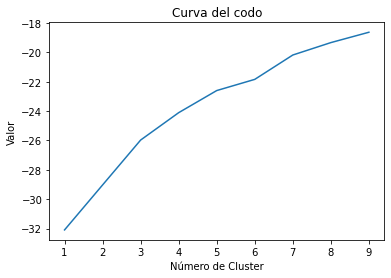

In [0]:

Nc = range(1, 10)
kmeans1 = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans1[i].fit(guayaquil_grouped_clustering).score(guayaquil_grouped_clustering) for i in range(len(kmeans1))]
plt.plot(Nc,score)
plt.xlabel('Número de Cluster')
plt.ylabel('Valor')
plt.title('Curva del codo')
plt.show()

In [0]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.rename(columns={'id':'Codigo'})
neighborhoods_venues_sorted.columns

Index(['Codigo', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [0]:
guayaquil_merged=[]
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))

In [0]:
guayaquil_merged = guayaquil_data

In [0]:
# merge guayaquil_grouped with guayaquil_data to add latitude/longitude for each codigo
guayaquil_merged = pd.merge(guayaquil_merged, neighborhoods_venues_sorted, on='Codigo')

In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(guayaquil_merged['latitud'], guayaquil_merged['longitud'], guayaquil_merged['Tipo'], guayaquil_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    numero = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
       color=rainbow[(cluster)-1],
        fill=True,
        fill_color=rainbow[(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [0]:
guayaquil_merged.loc[guayaquil_merged['Cluster Labels'] == 0, guayaquil_merged.columns[[1] + list(range(5, guayaquil_merged.shape[1]))]]

,CodTipo,ciudad,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Guayaquil,0,Dim Sum Restaurant,Gym,Coffee Shop,Paper / Office Supplies Store,Optical Shop,Theater,Women's Store,Fabric Shop,Empanada Restaurant,Electronics Store
1,1,Guayaquil,0,Sandwich Place,Pizza Place,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Bar,Restaurant,Sushi Restaurant,Japanese Restaurant,Ice Cream Shop
2,1,Guayaquil,0,Seafood Restaurant,BBQ Joint,Men's Store,Steakhouse,Burger Joint,Restaurant,South American Restaurant,Latin American Restaurant,Pool Hall,Food Truck
3,1,Guayaquil,0,Dim Sum Restaurant,Gym,Coffee Shop,Paper / Office Supplies Store,Optical Shop,Theater,Women's Store,Fabric Shop,Empanada Restaurant,Electronics Store
4,1,Guayaquil,0,Middle Eastern Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Chinese Restaurant,Dessert Shop,Pharmacy,Japanese Restaurant,Seafood Restaurant,Women's Store
5,1,Guayaquil,0,Sandwich Place,Seafood Restaurant,Restaurant,Ice Cream Shop,Pizza Place,Bar,Sushi Restaurant,Chinese Restaurant,Coffee Shop,Fast Food Restaurant
6,1,Guayaquil,0,Café,Hotel,History Museum,Seafood Restaurant,Restaurant,South American Restaurant,Latin American Restaurant,Miscellaneous Shop,Steakhouse,Food Court
7,1,Guayaquil,0,Café,Hotel,Plaza,Latin American Restaurant,BBQ Joint,Hotel Bar,Steakhouse,Coffee Shop,Deli / Bodega,Park
8,1,Guayaquil,0,Café,Hotel,Steakhouse,Bakery,Latin American Restaurant,Department Store,Plaza,Coffee Shop,BBQ Joint,Hotel Bar
9,1,Guayaquil,0,Gym,Supermarket,Pizza Place,Gym / Fitness Center,Professional & Other Places,Bus Stop,Pharmacy,Gas Station,Cupcake Shop,Dive Bar


In [0]:
guayaquil_merged.loc[guayaquil_merged['Cluster Labels'] == 1, guayaquil_merged.columns[[1] + list(range(5, guayaquil_merged.shape[1]))]]

,CodTipo,ciudad,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,1,Guayaquil,1,Music Venue,Women's Store,Diner,Farmers Market,Falafel Restaurant,Fabric Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar
32,1,Guayaquil,1,Music Venue,Women's Store,Diner,Farmers Market,Falafel Restaurant,Fabric Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar
119,1,Guayaquil,1,Restaurant,Music Venue,Women's Store,Dim Sum Restaurant,Falafel Restaurant,Fabric Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar
122,1,Guayaquil,1,Music Venue,Women's Store,Diner,Farmers Market,Falafel Restaurant,Fabric Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar


In [0]:
guayaquil_merged.groupby('Cluster Labels').count()

,Codigo,CodTipo,Tipo,longitud,latitud,ciudad,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,,
0,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


### Predict new point 

In [0]:
# We will predict with longitude and latitude to which cluster a point of attention belongs

punto_latitud = -2.1639058
punto_longitud = -79.9176766
ide =   "1001"
name = "Cajeros Automáticos"

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    punto_latitud, 
    punto_longitud, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=L3OJGFIAY2O3KWEHVYYKKULP2LMPA5RZ0JDVQYM1GYJGHTKC&client_secret=AUDQYCWOJT3JCTS4PHXELU4JZQJX4ECDVHKBVHZNGO2CMBJO&v=20180605&ll=-2.1639058,-79.9176766&radius=500&limit=100'

In [0]:
venues_list_predict=[]

# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']
        
# return only relevant information for each nearby venue
venues_list_predict.append([(
            ide,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

nearby_venues_predict = pd.DataFrame([item for venues_list_predict in venues_list_predict for item in venues_list_predict])
nearby_venues_predict.columns = ['id', 
                  'Tipo',
                  'Latitud', 
                  'Longitud', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

In [0]:
nearby_venues_predict.head(2)

,id,Tipo,Latitud,Longitud,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1001,Cajeros Automáticos,-2.172679,-79.907479,Salinerito,-2.162494,-79.918781,Pizza Place
1,1001,Cajeros Automáticos,-2.172679,-79.907479,La Carreta del Jefe,-2.162585,-79.917059,Food Truck


In [0]:
# one hot encoding
gye_onehot = pd.get_dummies(nearby_venues_predict[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
gye_onehot['id'] = nearby_venues_predict['id'] 

# move neighborhood column to the first column
fixed_columns = [gye_onehot.columns[-1]] + list(gye_onehot.columns[:-1])
gye_onehot = gye_onehot[fixed_columns]

guayaquil_grouped_predict = gye_onehot.groupby('id').mean().reset_index()


In [0]:
guayaquil_grouped_predict

,id,BBQ Joint,Bakery,Bar,Baseball Field,Basketball Court,Breakfast Spot,Burger Joint,Chinese Restaurant,Deli / Bodega,Food Truck,Hot Dog Joint,Latin American Restaurant,Mexican Restaurant,Pizza Place,Restaurant,Seafood Restaurant,Snack Place,South American Restaurant,Steakhouse
0,1001,0.064516,0.064516,0.032258,0.032258,0.032258,0.032258,0.064516,0.096774,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.032258,0.258065,0.032258,0.032258,0.032258


In [0]:
#### Agrego las columnas que faltan al dataframe para que se ajuste al modelo ####
original= guayaquil_grouped_clustering.shape[1]
frame_predict  = guayaquil_grouped_predict.shape[1]
diferencia = original - frame_predict

diferencia
i=0

while i < diferencia:
  guayaquil_grouped_predict[frame_predict+i] = 0
  i = i +1 

# Answer Questions
How do I classify a new point of attention.?

In [0]:
new_labels = kmeans.predict(guayaquil_grouped_predict)
print("Cluster asignado al nuevo punto ",new_labels)

Cluster asignado al nuevo punto  [0]
